In [ ]:
import pandas as pd

df_sample = pd.read_csv('your_taq_data.csv.gz')
print(df_sample.columns)
print(df_sample['SYM_ROOT'].unique())

/tmp/ipython-input-939297810.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sample = pd.read_csv('your_taq_data.csv.gz')


Index(['DATE', 'TIME_M', 'EX', 'SYM_ROOT', 'SYM_SUFFIX', 'TR_SCOND', 'SIZE',
       'PRICE'],
      dtype='object')
['AAPL' 'AMZN' 'CORN' 'DBA' 'GOOG' 'MSFT' 'NFLX' 'NVDA' 'TSLA']


In [ ]:
import pandas as pd

file_path = 'your_taq_data.csv.gz'

sample = pd.read_csv(file_path, compression='gzip', nrows=10)
print("Sample columns:", sample.columns)
print(sample.head())

df = pd.read_csv(file_path, compression='gzip', dtype={'SYM_ROOT': str})

print(f"Initial rows: {len(df)}")

expected_cols = ['DATE', 'TIME_M', 'PRICE', 'SYM_ROOT']
missing_cols = [c for c in expected_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in data: {missing_cols}")

df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
print(df['DATE'].head())

print(df['TIME_M'].head())

def parse_time_m(x):
    try:
        x = int(x)
        hh = x // 10000
        mm = (x % 10000) // 100
        ss = x % 100
        return pd.Timedelta(hours=hh, minutes=mm, seconds=ss)
    except:
        return pd.Timedelta(0)

if df['TIME_M'].dtype == 'object' or df['TIME_M'].max() < 86400:
    df['time_delta'] = df['TIME_M'].apply(parse_time_m)
else:
    df['time_delta'] = pd.to_timedelta(df['TIME_M'], unit='ms')

df['datetime'] = df['DATE'] + df['time_delta']

df = df.dropna(subset=['datetime', 'PRICE'])

print(df[['datetime', 'PRICE', 'SYM_ROOT']].head())

df.set_index('datetime', inplace=True)

Sample columns: Index(['DATE', 'TIME_M', 'EX', 'SYM_ROOT', 'SYM_SUFFIX', 'TR_SCOND', 'SIZE',
       'PRICE'],
      dtype='object')
         DATE             TIME_M EX SYM_ROOT  SYM_SUFFIX TR_SCOND  SIZE  PRICE
0  2025-07-21  4:00:00.033819922  K     AAPL         NaN     @ TI    17  211.7
1  2025-07-21  4:00:00.036344095  K     AAPL         NaN     @ TI    10  211.7
2  2025-07-21  4:00:00.036381980  K     AAPL         NaN     @ TI    23  211.7
3  2025-07-21  4:00:00.036388698  K     AAPL         NaN     @ TI    21  211.4
4  2025-07-21  4:00:00.037171743  K     AAPL         NaN     @ TI     5  212.0


/tmp/ipython-input-3257189857.py:12: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



Initial rows: 27620881
0   2025-07-21
1   2025-07-21
2   2025-07-21
3   2025-07-21
4   2025-07-21
Name: DATE, dtype: datetime64[ns]
0    4:00:00.033819922
1    4:00:00.036344095
2    4:00:00.036381980
3    4:00:00.036388698
4    4:00:00.037171743
Name: TIME_M, dtype: object


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from itertools import combinations

class TickDataProcessor:
    def __init__(self, tick_data, focus_assets=None):
        self.tick_data = tick_data.copy()
        self.focus_assets = set(focus_assets) if focus_assets else set()
        self.focus_diagnostics = {ticker: {'issues': [], 'found_in_raw': False} for ticker in self.focus_assets}

    def process_method(self, pandas_freq='15min', method='OHLC'):
        method_data = {}
        for ticker in sorted(self.tick_data['ticker'].unique()):
            ticker_data = self.tick_data[self.tick_data['ticker'] == ticker].copy()
            self.focus_diagnostics.get(ticker, {}).update({'found_in_raw': True})

            is_focus = ticker in self.focus_assets
            min_ticks_required = 20 if is_focus else 100

            if len(ticker_data) < min_ticks_required:
                continue

            ticker_data = ticker_data.set_index('datetime').sort_index()

            try:
                bars = self._create_bars_single_method(ticker_data, pandas_freq, method)
                min_bars_required = 2 if is_focus else 10
                if len(bars) >= min_bars_required:
                    method_data[ticker] = bars
            except Exception as e:
                print(f"Error processing {ticker} with {method}: {e}")

        return method_data

    def _create_bars_single_method(self, ticker_data, pandas_freq, method):
        if method == 'OHLC':
            ohlc = ticker_data['price'].resample(pandas_freq).agg(['first', 'max', 'min', 'last'])
            volume = ticker_data['size'].resample(pandas_freq).sum()
            bars = pd.DataFrame({
                'Open': ohlc['first'],
                'High': ohlc['max'],
                'Low': ohlc['min'],
                'Close': ohlc['last'],
                'Volume': volume
            })
            bars['Returns'] = bars['Close'].pct_change()
        else:
            raise ValueError(f"Method '{method}' not implemented.")
        return bars.dropna()

file_path = 'your_taq_data.csv.gz'

print("Loading tick data...")
tick_data = pd.read_csv(file_path, compression='gzip', dtype={'ticker': str})

tick_data['datetime'] = pd.to_datetime(tick_data['DATE']) + pd.to_timedelta(tick_data['TIME_M'])

tick_data.rename(columns={'SYM_ROOT': 'ticker', 'PRICE': 'price', 'SIZE': 'size'}, inplace=True)

processor = TickDataProcessor(tick_data, focus_assets=['AAPL', 'MSFT'])
bars_by_ticker = processor.process_method(pandas_freq='15min', method='OHLC')

all_bars_list = []
for ticker, bars in bars_by_ticker.items():
    bars = bars.copy()
    bars['ticker'] = ticker
    bars.reset_index(inplace=True)
    all_bars_list.append(bars[['datetime', 'ticker', 'Close']])

all_bars = pd.concat(all_bars_list)
print("Bars created for tickers:", all_bars['ticker'].unique())

pivot_close = all_bars.pivot(index='datetime', columns='ticker', values='Close').sort_index()

pivot_close = pivot_close.ffill().bfill()

pivot_close = pivot_close.dropna(axis=1)
tickers = pivot_close.columns.tolist()
print(f"Tickers after cleaning: {len(tickers)}")

if len(tickers) < 2:
    raise ValueError("Not enough tickers after cleaning to compute S1.")

returns = pivot_close.pct_change().dropna()
returns = returns.cumsum()

def expectation_ab(x_mask, y_mask, a, b):
    mask = x_mask & y_mask
    if mask.sum() == 0:
        return 0.0
    return np.mean(a[mask] * b[mask])

window_size = 20
threshold_quantile = 0.75
s1_violations = []
s1_time_series = {pair: [] for pair in combinations(tickers, 2)}

print("Calculating Bell S1 values...")
for T in range(window_size, len(returns)):
    window_returns = returns.iloc[T - window_size:T]
    thresholds = window_returns.abs().quantile(threshold_quantile)
    s1_values = []
    for stock_A, stock_B in combinations(window_returns.columns, 2):
        RA = window_returns[stock_A]
        RB = window_returns[stock_B]
        a = np.sign(RA)
        b = np.sign(RB)
        x0 = RA.abs() >= thresholds[stock_A]
        x1 = ~x0
        y0 = RB.abs() >= thresholds[stock_B]
        y1 = ~y0
        ab_00 = expectation_ab(x0, y0, a, b)
        ab_01 = expectation_ab(x0, y1, a, b)
        ab_10 = expectation_ab(x1, y0, a, b)
        ab_11 = expectation_ab(x1, y1, a, b)
        S1 = ab_00 + ab_01 + ab_10 - ab_11
        s1_values.append((stock_A, stock_B, S1))
        s1_time_series[(stock_A, stock_B)].append(S1)
    violations = sum(abs(s1) > 2 for _, _, s1 in s1_values)
    violation_pct = 100 * violations / len(s1_values)
    s1_violations.append({'timestamp': returns.index[T], 'violation_%': violation_pct})

violation_df = pd.DataFrame(s1_violations).set_index('timestamp')

pdf_path = 'bell_s1_violations_and_pairs.pdf'
with PdfPages(pdf_path) as pdf:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(violation_df.index, violation_df['violation_%'], label='S1 Violation %')
    ax.axhline(50, color='red', linestyle='--', label='50% Threshold', alpha=0.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('% of Pairs Violating |S1| > 2')
    ax.set_title('Bell S1 Violations Over Time (15-min Aggregates)')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

    classical_limit = 2
    quantum_limit = 2 * np.sqrt(2)
    pairs = list(s1_time_series.keys())
    pairs_per_page = 4

    for start_idx in range(0, len(pairs), pairs_per_page):
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        axs = axs.flatten()
        for i, pair_idx in enumerate(range(start_idx, min(start_idx + pairs_per_page, len(pairs)))):
            pair = pairs[pair_idx]
            s1_vals = s1_time_series[pair]
            times = violation_df.index[-len(s1_vals):]
            axs[i].plot(times, s1_vals, label=f'S1 {pair[0]}-{pair[1]}')
            axs[i].axhline(classical_limit, color='red', linestyle='--', label='Classical Limit (+2)')
            axs[i].axhline(-classical_limit, color='red', linestyle='--')
            axs[i].axhline(quantum_limit, color='blue', linestyle='-.', label='Quantum Limit (+2√2)')
            axs[i].axhline(-quantum_limit, color='blue', linestyle='-.')
            axs[i].set_title(f'S1 Value: {pair[0]} vs {pair[1]}')
            axs[i].set_xlabel('Time')
            axs[i].set_ylabel('S1 Value')
            axs[i].grid(True)
            axs[i].legend(fontsize='small')
        for j in range(i + 1, pairs_per_page):
            fig.delaxes(axs[j])
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

print(f"Plots saved to {pdf_path}")

Loading tick data...


/tmp/ipython-input-1071031018.py:58: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tick_data = pd.read_csv(file_path, compression='gzip', dtype={'ticker': str})
/tmp/ipython-input-1071031018.py:48: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  bars['Returns'] = bars['Close'].pct_change()
/tmp/ipython-input-1071031018.py:48: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  bars['Returns'] = bars['Close'].pct_change()
/tmp/ipython-input-1071031018.py:48: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be 

Bars created for tickers: ['AAPL' 'AMZN' 'CORN' 'DBA' 'GOOG' 'MSFT' 'NFLX' 'NVDA' 'TSLA']
Tickers after cleaning: 9
Calculating Bell S1 values...
Plots saved to bell_s1_violations_and_pairs.pdf


#Yahoo Finance

/tmp/ipython-input-2422528526.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


PDF saved as s1_analysis.pdf


/tmp/ipython-input-2422528526.py:208: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


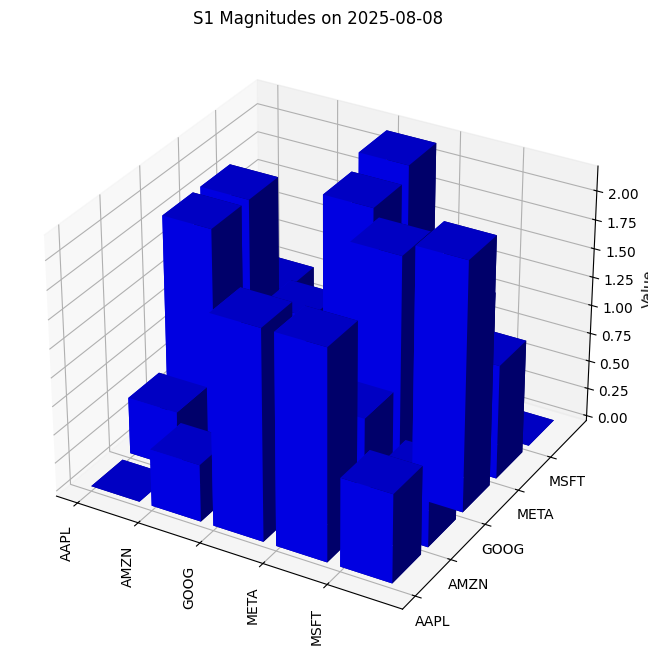

/tmp/ipython-input-2422528526.py:208: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


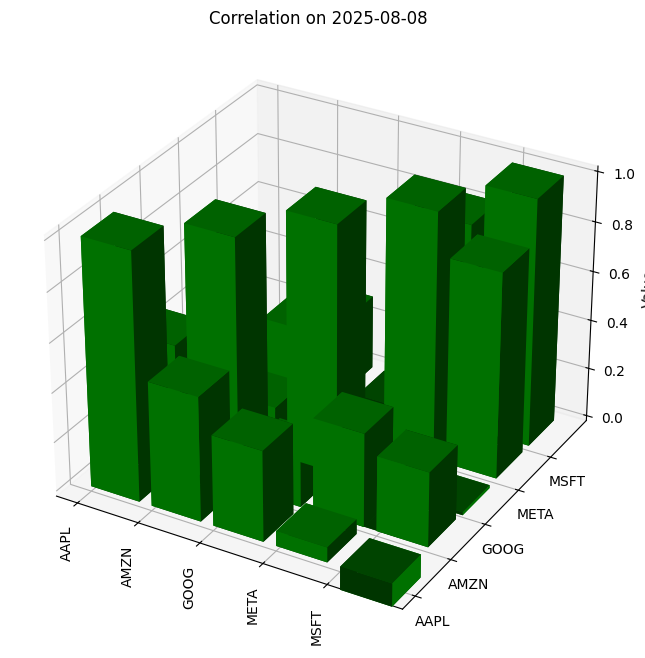

/tmp/ipython-input-2422528526.py:267: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


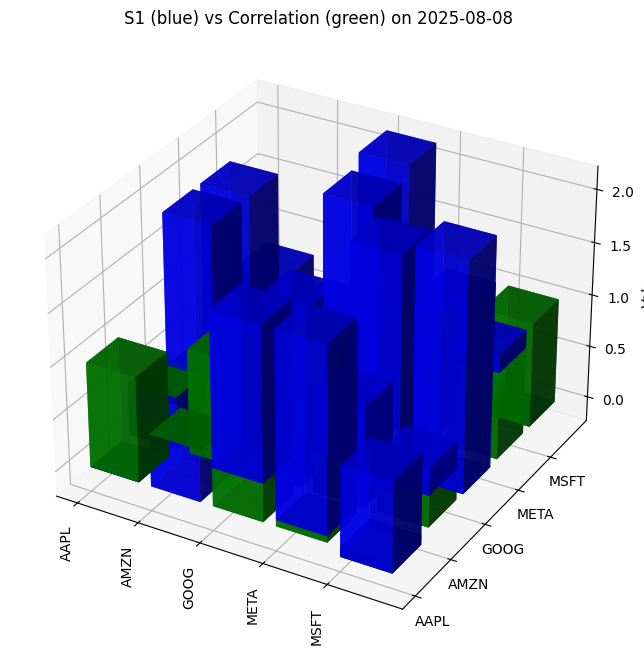

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from datetime import datetime, timedelta
from matplotlib.backends.backend_pdf import PdfPages

# --- Double tickers to 40 ---
#tickers = [
#    "AAPL","MSFT","GOOGL","AMZN","META","TSLA","NVDA","NFLX","JPM","BAC",
#    "WFC","V","MA","XOM","CVX","PFE","JNJ","KO","PEP","DIS",
#    "CSCO","ORCL","IBM","INTC","MCD"
#]
tickers = ['AAPL', 'MSFT', 'GOOG', 'META', 'AMZN']
days_back = 140
window_size = 20
threshold_quantile = 0.75

end_date = datetime.today()
start_date = end_date - timedelta(days=days_back*2)

# --- Download data ---
data = yf.download(tickers, start=start_date, end=end_date)

if isinstance(data.columns, pd.MultiIndex):
    if 'Adj Close' in data.columns.levels[0]:
        data = data['Adj Close']
    elif 'Close' in data.columns.levels[0]:
        data = data['Close']
    else:
        raise ValueError("Neither 'Adj Close' nor 'Close' found.")
else:
    if 'Adj Close' in data.columns:
        data = data['Adj Close']
    elif 'Close' in data.columns:
        data = data['Close']
    else:
        raise ValueError("Neither 'Adj Close' nor 'Close' found.")

data = data.dropna(axis=1)  # drop tickers with missing data
returns = data.pct_change().dropna()

# --- S1 helper ---
def expectation_ab(x_mask, y_mask, a, b):
    mask = x_mask & y_mask
    if mask.sum() == 0:
        return 0.0
    return np.mean(a[mask] * b[mask])

# --- Store results ---
s1_time_series = {pair: [] for pair in combinations(returns.columns, 2)}
s1_violations = []

for T in range(window_size, len(returns)):
    window_returns = returns.iloc[T - window_size:T]
    thresholds = window_returns.abs().quantile(threshold_quantile)

    s1_values = []
    for stock_A, stock_B in combinations(returns.columns, 2):
        RA = window_returns[stock_A]
        RB = window_returns[stock_B]

        a = np.sign(RA)
        b = np.sign(RB)

        x0 = RA.abs() >= thresholds[stock_A]
        x1 = ~x0
        y0 = RB.abs() >= thresholds[stock_B]
        y1 = ~y0

        ab_00 = expectation_ab(x0, y0, a, b)
        ab_01 = expectation_ab(x0, y1, a, b)
        ab_10 = expectation_ab(x1, y0, a, b)
        ab_11 = expectation_ab(x1, y1, a, b)

        S1 = ab_00 + ab_01 + ab_10 - ab_11
        s1_time_series[(stock_A, stock_B)].append((returns.index[T], S1))
        s1_values.append(S1)

    violations = sum(abs(s1) > 2 for s1 in s1_values)
    total_pairs = len(s1_values)
    if total_pairs == 0:
      continue  # Skip this time step if no pairs

    violation_pct = 100 * violations / total_pairs

    s1_violations.append({
        'date': returns.index[T],
        'violation_%': violation_pct
    })

# --- Save plots to PDF ---
violation_df = pd.DataFrame(s1_violations)

from itertools import islice

pairs = list(s1_time_series.items())

with PdfPages("s1_analysis.pdf") as pdf:
    # Page 1: violation % plot
    plt.figure(figsize=(10, 5))
    plt.plot(violation_df['date'], violation_df['violation_%'], label='S1 Violation %')
    plt.axhline(50, color='red', linestyle='--', label='Threshold', alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('% of Pairs Violating |S1| > 2')
    plt.title('Bell S1 Violations Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # Pages with 6 plots each
    for i in range(0, len(pairs), 6):
        fig, axes = plt.subplots(3, 2, figsize=(10, 12))
        axes = axes.flatten()

        for ax, ((stock_A, stock_B), values) in zip(axes, islice(pairs, i, i + 6)):
            if not values:
                ax.axis("off")
                continue
            dates, s1_vals = zip(*values)
            s1_abs = np.abs(s1_vals)  # magnitude of S1
            ax.plot(dates, s1_abs, label=f"|S1|: {stock_A}-{stock_B}")
            ax.axhline(2, color='red', linestyle='--', alpha=0.5)
            ax.axhline(2*np.sqrt(2), color='green', linestyle='--', alpha=0.5)
            ax.set_xlabel("Date")
            ax.set_ylabel("|S1| Value")
            ax.set_title(f"{stock_A} & {stock_B}")
            ax.grid(True)
            ax.legend(fontsize=8)

        # Turn off unused axes if fewer than 6 plots
        for j in range(len(values), 6):
            axes[j].axis("off")

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

print("PDF saved as s1_analysis.pdf")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Get most recent S1 and correlation data ---
latest_date = returns.index[-1]
latest_returns = returns.iloc[-window_size:]

# Compute thresholds and S1 for latest window
thresholds = latest_returns.abs().quantile(threshold_quantile)

s1_matrix = np.zeros((len(returns.columns), len(returns.columns)))
corr_matrix = latest_returns.corr().values

for i, stock_A in enumerate(returns.columns):
    for j, stock_B in enumerate(returns.columns):
        if i == j:
            s1_matrix[i, j] = np.nan
            continue

        RA = latest_returns[stock_A]
        RB = latest_returns[stock_B]

        a = np.sign(RA)
        b = np.sign(RB)

        x0 = RA.abs() >= thresholds[stock_A]
        x1 = ~x0
        y0 = RB.abs() >= thresholds[stock_B]
        y1 = ~y0

        def expectation_ab(x_mask, y_mask):
            mask = x_mask & y_mask
            if mask.sum() == 0:
                return 0.0
            return np.mean(a[mask] * b[mask])

        ab_00 = expectation_ab(x0, y0)
        ab_01 = expectation_ab(x0, y1)
        ab_10 = expectation_ab(x1, y0)
        ab_11 = expectation_ab(x1, y1)

        S1 = ab_00 + ab_01 + ab_10 - ab_11
        s1_matrix[i, j] = abs(S1)  # magnitude only

# --- Helper: 3D bar plot function ---
def plot_3d_bars(matrix, title, color):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    _x = np.arange(matrix.shape[0])
    _y = np.arange(matrix.shape[1])
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    z = np.zeros_like(x)
    dz = np.nan_to_num(matrix.ravel())

    ax.bar3d(x, y, z, 0.8, 0.8, dz, shade=True, color=color)
    ax.set_xticks(range(len(returns.columns)))
    ax.set_yticks(range(len(returns.columns)))
    ax.set_xticklabels(returns.columns, rotation=90)
    ax.set_yticklabels(returns.columns)
    ax.set_zlabel("Value")
    ax.set_title(title)
    plt.tight_layout()
    return fig

# Plot 1: S1 magnitudes
fig1 = plot_3d_bars(s1_matrix, f"S1 Magnitudes on {latest_date.date()}", 'blue')
plt.show()

# Plot 2: Correlation matrix
fig2 = plot_3d_bars(corr_matrix, f"Correlation on {latest_date.date()}", 'green')
plt.show()

# Plot 3: Superimposed stacked bars (bottom = smaller, top = larger)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

_x = np.arange(len(returns.columns))
_y = np.arange(len(returns.columns))
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
z = np.zeros_like(x)

s1_vals = np.nan_to_num(s1_matrix.ravel())
corr_vals = np.nan_to_num(corr_matrix.ravel())

bottom_color = []
top_color = []
bottom_height = []
top_height = []

for s1_val, corr_val in zip(s1_vals, corr_vals):
    if corr_val >= s1_val:
        # Bottom: S1 (blue), Top: correlation excess (green)
        bottom_height.append(s1_val)
        top_height.append(corr_val - s1_val)
        bottom_color.append('blue')
        top_color.append('green')
    else:
        # Bottom: correlation (green), Top: S1 excess (blue)
        bottom_height.append(corr_val)
        top_height.append(s1_val - corr_val)
        bottom_color.append('green')
        top_color.append('blue')

# Plot bottom segments
ax.bar3d(x, y, z,
         0.8, 0.8, bottom_height,
         color=bottom_color, alpha=0.8)

# Plot top segments stacked on bottom
ax.bar3d(x, y, bottom_height,
         0.8, 0.8, top_height,
         color=top_color, alpha=0.8)

ax.set_xticks(range(len(returns.columns)))
ax.set_yticks(range(len(returns.columns)))
ax.set_xticklabels(returns.columns, rotation=90)
ax.set_yticklabels(returns.columns)
ax.set_zlabel("Value")
ax.set_title(f"S1 (blue) vs Correlation (green) on {latest_date.date()}")
plt.tight_layout()
plt.show()


#Pairwise Sample

/tmp/ipython-input-2491230073.py:20: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  2 of 2 completed


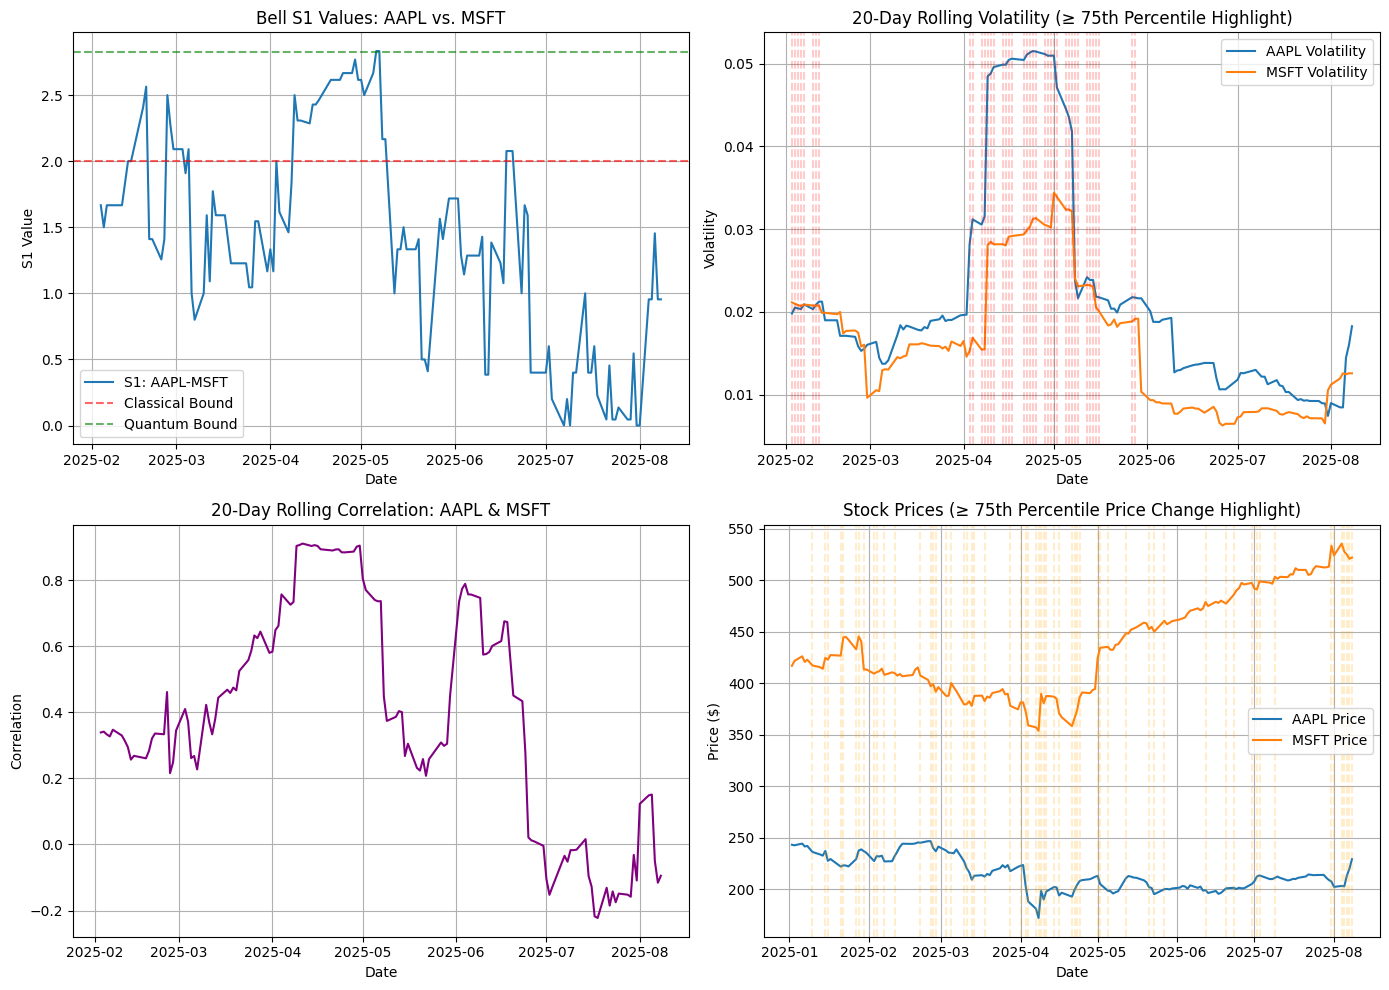

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

ticker_A = 'AAPL'
ticker_B = 'MSFT'
start_date = datetime(2025, 1, 1)
end_date = datetime.today()
window_size = 20
threshold_quantile = 0.75

data = yf.download([ticker_A, ticker_B], start=start_date, end=end_date)

if isinstance(data.columns, pd.MultiIndex):
    if 'Adj Close' in data.columns.levels[0]:
        data = data['Adj Close']
    elif 'Close' in data.columns.levels[0]:
        data = data['Close']
    else:
        raise ValueError("Price data not found in multi-index DataFrame.")
else:
    if 'Adj Close' in data.columns:
        data = data['Adj Close']
    elif 'Close' in data.columns:
        data = data['Close']
    else:
        raise ValueError("Price data not found in flat DataFrame.")

data = data[[ticker_A, ticker_B]].dropna()
returns = data.pct_change().dropna()

def expectation_ab(x_mask, y_mask, a, b):
    mask = x_mask & y_mask
    if mask.sum() == 0:
        return 0.0
    return np.mean(a[mask] * b[mask])

s1_series = []
for T in range(window_size, len(returns)):
    window_returns = returns.iloc[T - window_size:T]
    thresholds = window_returns.abs().quantile(threshold_quantile)

    RA = window_returns[ticker_A]
    RB = window_returns[ticker_B]

    a = np.sign(RA)
    b = np.sign(RB)

    x0 = RA.abs() >= thresholds[ticker_A]
    x1 = ~x0
    y0 = RB.abs() >= thresholds[ticker_B]
    y1 = ~y0

    ab_00 = expectation_ab(x0, y0, a, b)
    ab_01 = expectation_ab(x0, y1, a, b)
    ab_10 = expectation_ab(x1, y0, a, b)
    ab_11 = expectation_ab(x1, y1, a, b)

    S1 = ab_00 + ab_01 + ab_10 - ab_11
    s1_series.append({'date': returns.index[T], 'S1_value': S1})

s1_df = pd.DataFrame(s1_series)

volatility = returns.rolling(window=20).std()
vol_threshold = volatility.quantile(0.75)
high_vol_dates = volatility[(volatility[ticker_A] >= vol_threshold[ticker_A]) |
                             (volatility[ticker_B] >= vol_threshold[ticker_B])].index

price_changes = returns.abs()
price_threshold = price_changes.quantile(0.75)
high_price_dates = price_changes[(price_changes[ticker_A] >= price_threshold[ticker_A]) |
                                 (price_changes[ticker_B] >= price_threshold[ticker_B])].index

rolling_corr = returns[ticker_A].rolling(window=20).corr(returns[ticker_B])

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(s1_df['date'], np.abs(s1_df['S1_value']), label=f'S1: {ticker_A}-{ticker_B}')
axs[0, 0].axhline(2, color='red', linestyle='--', alpha=0.6, label='Classical Bound')
axs[0, 0].axhline(2*np.sqrt(2), color='green', linestyle='--', alpha=0.6, label='Quantum Bound')
axs[0, 0].set_title(f'Bell S1 Values: {ticker_A} vs. {ticker_B}')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('S1 Value')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].plot(volatility.index, volatility[ticker_A], label=f'{ticker_A} Volatility')
axs[0, 1].plot(volatility.index, volatility[ticker_B], label=f'{ticker_B} Volatility')
for d in high_vol_dates:
    axs[0, 1].axvline(d, color='red', linestyle='--', alpha=0.2)
axs[0, 1].set_title('20-Day Rolling Volatility (≥ 75th Percentile Highlight)')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Volatility')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 1].plot(data.index, data[ticker_A], label=f'{ticker_A} Price')
axs[1, 1].plot(data.index, data[ticker_B], label=f'{ticker_B} Price')
for d in high_price_dates:
    axs[1, 1].axvline(d, color='orange', linestyle='--', alpha=0.2)
axs[1, 1].set_title('Stock Prices (≥ 75th Percentile Price Change Highlight)')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price ($)')
axs[1, 1].legend()
axs[1, 1].grid(True)

axs[1, 0].plot(rolling_corr.index, rolling_corr, color='purple')
axs[1, 0].set_title(f'20-Day Rolling Correlation: {ticker_A} & {ticker_B}')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Correlation')
axs[1, 0].grid(True)

plt.tight_layout()
plt.show()



In [ ]:
import plotly.graph_objects as go
import numpy as np

def make_bar(x_center, y_center, width, depth, height, color):
    """
    Creates vertices for a 3D bar (rectangular prism) using Mesh3d.
    """
    x0, x1 = x_center - width/2, x_center + width/2
    y0, y1 = y_center - depth/2, y_center + depth/2
    z0, z1 = 0, height

    vertices = np.array([
        [x0, y0, z0], [x1, y0, z0], [x1, y1, z0], [x0, y1, z0],  # bottom
        [x0, y0, z1], [x1, y0, z1], [x1, y1, z1], [x0, y1, z1]   # top
    ])

    faces = np.array([
        [0, 1, 2], [0, 2, 3],  # bottom
        [4, 5, 6], [4, 6, 7],  # top
        [0, 1, 5], [0, 5, 4],  # front
        [1, 2, 6], [1, 6, 5],  # right
        [2, 3, 7], [2, 7, 6],  # back
        [3, 0, 4], [3, 4, 7]   # left
    ])

    return go.Mesh3d(
        x=vertices[:,0], y=vertices[:,1], z=vertices[:,2],
        i=faces[:,0], j=faces[:,1], k=faces[:,2],
        color=color, opacity=0.9
    )

# Extract data
dates = s1_df['date']
s1_values = s1_df['S1_value']

# Animation frames
frames = []
for i in range(len(s1_values)):
    bar = make_bar(0, 0, 0.8, 0.8, s1_values[i], 'blue')
    frames.append(go.Frame(data=[bar], name=str(dates[i].date())))

# Initial frame
init_bar = make_bar(0, 0, 0.8, 0.8, s1_values[0], 'blue')

fig = go.Figure(
    data=[init_bar],
    layout=go.Layout(
        title="Animated 3D Bar of S1 Values Over Time",
        scene=dict(
            xaxis=dict(title="X", range=[-1, 1]),
            yaxis=dict(title="Y", range=[-1, 1]),
            zaxis=dict(title="S1 Value", range=[min(0, s1_values.min()), s1_values.max() + 0.5]),
        ),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(label="Play",
                         method="animate",
                         args=[None, {"frame": {"duration": 200, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause",
                         method="animate",
                         args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                ]
            )
        ]
    ),
    frames=frames
)

fig.show()



#Chot's Mean Method

/tmp/ipython-input-2-2740017712.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


          date  violation_%
136 2025-07-22          0.0
137 2025-07-23          0.0
138 2025-07-24          0.0
139 2025-07-25          0.0
140 2025-07-28          0.0


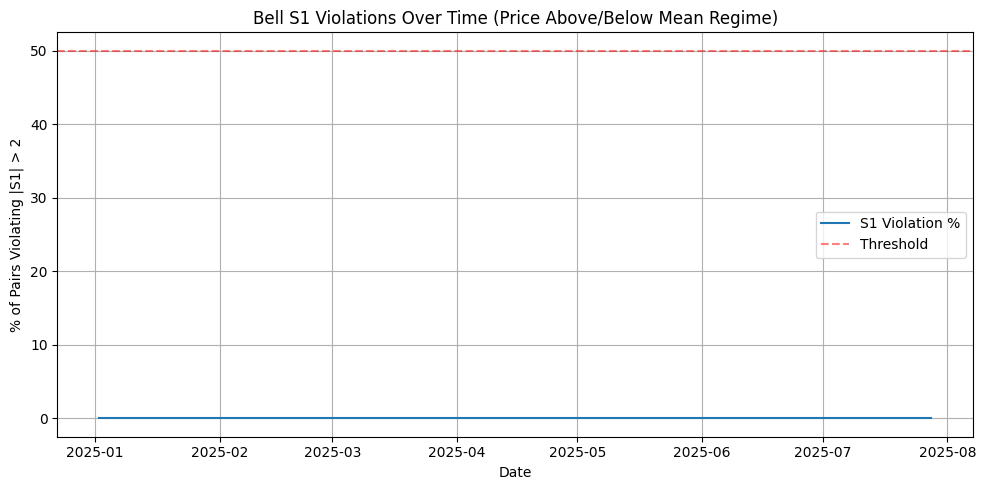

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from datetime import datetime, timedelta

tickers = ['AAPL', 'MSFT', 'GOOG', 'META', 'AMZN']
days_back = 140
window_size = 20

end_date = datetime.today()
start_date = datetime(2024, 12, 1)
data = yf.download(tickers, start=start_date, end=end_date)

if isinstance(data.columns, pd.MultiIndex):
    if 'Adj Close' in data.columns.levels[0]:
        data = data['Adj Close']
    elif 'Close' in data.columns.levels[0]:
        data = data['Close']
    else:
        raise ValueError("Neither 'Adj Close' nor 'Close' found in multi-index data.")
else:
    if 'Adj Close' in data.columns:
        data = data['Adj Close']
    elif 'Close' in data.columns:
        data = data['Close']
    else:
        raise ValueError("Neither 'Adj Close' nor 'Close' found in flat data.")

data = data.dropna()

returns = data.pct_change().dropna()

mean_prices = data.mean()

def expectation_ab(x_mask, y_mask, a, b):
    aligned_index = x_mask.index.intersection(y_mask.index).intersection(a.index).intersection(b.index)

    x_mask_aligned = x_mask.loc[aligned_index]
    y_mask_aligned = y_mask.loc[aligned_index]
    a_aligned = a.loc[aligned_index]
    b_aligned = b.loc[aligned_index]

    mask = x_mask_aligned & y_mask_aligned

    if mask.sum() == 0:
        return 0.0
    return np.mean(a_aligned[mask] * b_aligned[mask])

s1_violations = []

for T in range(window_size, len(returns)):
    window_returns = returns.iloc[T - window_size:T]
    window_prices = data.iloc[T - window_size:T]

    s1_values = []

    for stock_A, stock_B in combinations(tickers, 2):
        RA = window_returns[stock_A]
        RB = window_returns[stock_B]

        a = pd.Series(np.sign(RA), index=RA.index)
        b = pd.Series(np.sign(RB), index=RB.index)

        x0 = window_prices[stock_A] > mean_prices[stock_A]
        x1 = ~x0

        y0 = window_prices[stock_B] > mean_prices[stock_B]
        y1 = ~y0

        ab_00 = expectation_ab(x0, y0, a, b)
        ab_01 = expectation_ab(x0, y1, a, b)
        ab_10 = expectation_ab(x1, y0, a, b)
        ab_11 = expectation_ab(x1, y1, a, b)

        S1 = ab_00 + ab_01 + ab_10 - ab_11
        s1_values.append((stock_A, stock_B, S1))

    violations = sum(abs(s1) > 2 for _, _, s1 in s1_values)
    total_pairs = len(s1_values)
    violation_pct = 100 * violations / total_pairs

    s1_violations.append({
        'date': returns.index[T],
        'violation_%': violation_pct
    })

violation_df = pd.DataFrame(s1_violations)

print(violation_df.tail())

plt.figure(figsize=(10, 5))
plt.plot(violation_df['date'], violation_df['violation_%'], label='S1 Violation %')
plt.axhline(50, color='red', linestyle='--', label='Threshold', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('% of Pairs Violating |S1| > 2')
plt.title('Bell S1 Violations Over Time (Price Above/Below Mean Regime)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

